# **🤝 Collaborative Filtering** 

While item-based collaborative filtering and user-based collaborative filtering are referred to as memory-based in the literature, model-based collaborative filtering is referred to as the latent factor model.

- **Item Based Collaborative Filtering:** Recommendations are made based on item similarity. For example, a film similar to the liking features of a watched film is recommended. It has no relation to content similarity. I want to make a decision according to the consensus of the community.


- **User Based Collaborative Filtering:** Recommendations are made based on user similarities. Let's say I watched a movie and liked it. Others also watched the same movie and liked it. Then I want to watch another movie. They recommend me the other movie that people who liked the movie I liked also liked. In other methods, we were only interested in a person's contact with other films.

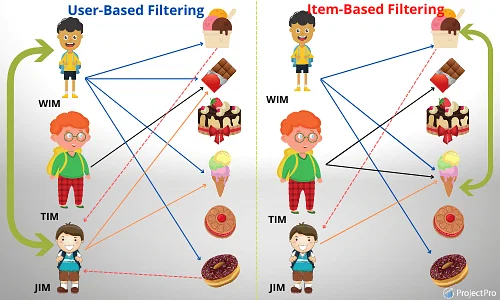

# **Business Problem**

Use item-based and user-based recommender methods to make predictions for the user with the given ID.
Consider 5 recommendations from the user-based model and 5 recommendations from the item-based model and make a total of 10 recommendations from 2 models.



# **About Dataset**

**Content**

The Book-Crossing dataset comprises 3 files.

* **Users**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.
* **Books**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.
* **Ratings**

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Users.csv

In [1]:
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/Books.csv


# **Task 1: Data Preparation**

* **Step 1:** 
Read the Book and Rating datasets.
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)

rating = pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")
books = pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


* **Step 2:** By using the ISBN, which is the unique code used for books, the two data sets we added before, named books and ratings, are combined.

In [5]:
df = rating.merge(books, how="left", on="ISBN")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User-ID              1149780 non-null  int64 
 1   ISBN                 1149780 non-null  object
 2   Book-Rating          1149780 non-null  int64 
 3   Book-Title           1031136 non-null  object
 4   Book-Author          1031135 non-null  object
 5   Year-Of-Publication  1031136 non-null  object
 6   Publisher            1031134 non-null  object
 7   Image-URL-S          1031136 non-null  object
 8   Image-URL-M          1031136 non-null  object
 9   Image-URL-L          1031132 non-null  object
dtypes: int64(2), object(8)
memory usage: 96.5+ MB


* **Step 3:** Calculate the total number of people who voted for each book.Store the names of books with less than 15 total votes in rare_books. And remove them from the dataset.

In [6]:
rating_count = pd.DataFrame(df["Book-Title"].value_counts())
rating_count.head()

,Book-Title
Wild Animus,2502
The Lovely Bones: A Novel,1295
The Da Vinci Code,898
A Painted House,838
The Nanny Diaries: A Novel,828


In [7]:
rare_rating_count = rating_count[rating_count["Book-Title"] < 600].index
rare_rating_count.size

241056

In [8]:
common_rating_count = df[~df["Book-Title"].isin(rare_rating_count)]
common_rating_count.size

1319750

* **Step 4:** Create a pivot table for the dataframe where the User-ID's are in the index, Books Titles are in the columns, and the ratings are in the values.

In [9]:
book_df = common_rating_count.pivot_table(index=["User-ID"], columns=["Book-Title"], values="Book-Rating")
book_df.iloc[0:10, 0:10]

Book-Title,A Painted House,Angels &amp; Demons,Bridget Jones's Diary,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Life of Pi,Snow Falling on Cedars,The Da Vinci Code,The Lovely Bones: A Novel,The Nanny Diaries: A Novel,The Notebook
User-ID,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,7.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
244,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [10]:
book_df

Book-Title,A Painted House,Angels &amp; Demons,Bridget Jones's Diary,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Life of Pi,Snow Falling on Cedars,The Da Vinci Code,The Lovely Bones: A Novel,The Nanny Diaries: A Novel,The Notebook,The Red Tent (Bestselling Backlist),The Secret Life of Bees,The Summons,The Testament,Wild Animus
User-ID,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
114,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
232,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
278554,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278633,NaN,NaN,2.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Task 2: Determining the Films Watched by the User to be Recommended**

* **Step 1:** Select a random User-ID.

In [11]:
#random_user = int(pd.Series(book_df.index).sample(1).values)
random_user = 230522

* **Step 2:** Create a new dataframe named random_user_df consisting of observation units belonging to the selected user.

In [12]:
random_user_df = book_df[book_df.index == random_user]
random_user_df

Book-Title,A Painted House,Angels &amp; Demons,Bridget Jones's Diary,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Life of Pi,Snow Falling on Cedars,The Da Vinci Code,The Lovely Bones: A Novel,The Nanny Diaries: A Novel,The Notebook,The Red Tent (Bestselling Backlist),The Secret Life of Bees,The Summons,The Testament,Wild Animus
User-ID,,,,,,,,,,,,,,,
230522,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,NaN


* **Step 3:** Assign the books that the selected user rated to a list called books_watched.

In [13]:
books_read = random_user_df.columns[random_user_df.notna().any()].tolist()
books_read

['A Painted House',
 'Angels &amp; Demons',
 "Bridget Jones's Diary",
 'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
 'Life of Pi',
 'Snow Falling on Cedars',
 'The Da Vinci Code',
 'The Lovely Bones: A Novel',
 'The Nanny Diaries: A Novel',
 'The Notebook',
 'The Red Tent (Bestselling Backlist)',
 'The Secret Life of Bees',
 'The Summons',
 'The Testament']

# **Task 3: Accessing the Data and IDs of Other Users Who Read the Same Books**

* **Step 1:** Select the columns related to the books read by the selected user from random_user_df and create a new dataframe named books_read_df.

In [14]:
books_read_df = book_df[books_read]

* **Step 2:** Create a new dataframe named user_book_count that contains information about how many of the selected user's read books were read by each user.

In [15]:
user_book_count = books_read_df.T.notnull().sum()
user_book_count = user_book_count.reset_index()
user_book_count.columns = ["User-ID", "Book-Count"]
user_book_count

,User-ID,Book-Count
0,9,1
1,14,0
2,114,1
3,193,0
4,232,1
...,...,...
8311,278543,1
8312,278554,1
8313,278633,2
8314,278698,1


* **Step 3:** Consider users who have read at least 60% of the books_read_df rated by the selected user as similar users. Create a list named users_same_books from the IDs of these users.

In [16]:
perc = len(books_read) * 55 / 100
users_same_books = user_book_count[user_book_count["Book-Count"] >= perc]["User-ID"]
users_same_books

170       6575
194       7283
196       7346
312      11676
355      13273
         ...  
7815    260897
7840    261829
7942    265115
7997    266865
8043    268622
Name: User-ID, Length: 76, dtype: int64

# **Task 4: Determining the Users Most Similar to the User to be Recommended**

* **Step 1:** Filter the books_read_df dataframe so that it contains the ids of users who show similarity with the selected user in the user_same_books list.

In [17]:
final_df = pd.concat([books_read_df[books_read_df.index.isin(users_same_books)], random_user_df[books_read]])
final_df

Book-Title,A Painted House,Angels &amp; Demons,Bridget Jones's Diary,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Life of Pi,Snow Falling on Cedars,The Da Vinci Code,The Lovely Bones: A Novel,The Nanny Diaries: A Novel,The Notebook,The Red Tent (Bestselling Backlist),The Secret Life of Bees,The Summons,The Testament
User-ID,,,,,,,,,,,,,,
6575,NaN,NaN,2.666667,8.0,NaN,7.0,0.0,0.0,0.0,NaN,8.0,8.0,NaN,0.0
7283,10.0,NaN,0.000000,NaN,0.0,NaN,9.0,0.0,9.0,NaN,0.0,0.0,NaN,NaN
7346,NaN,NaN,0.000000,0.0,NaN,0.0,NaN,0.0,0.0,0.000000,NaN,NaN,8.0,9.0
11676,9.0,4.0,3.800000,0.0,4.0,10.0,9.0,5.0,7.5,8.666667,10.0,6.0,8.0,7.0
13273,0.0,8.0,NaN,NaN,0.0,0.0,9.0,8.0,NaN,NaN,NaN,9.0,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261829,0.0,9.0,5.000000,NaN,8.0,8.0,0.0,9.0,0.0,NaN,9.0,NaN,7.0,0.0
265115,NaN,NaN,7.000000,0.0,0.0,NaN,0.0,NaN,NaN,0.000000,0.0,0.0,0.0,0.0
266865,NaN,0.0,0.000000,0.0,NaN,0.0,0.0,8.0,NaN,NaN,0.0,7.0,NaN,NaN


* **Step 2:** Create a new dataframe named corr_df which will contain the correlations between users.

In [18]:
corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ["user_id_1", "user_id_2"]
corr_df = corr_df.reset_index()
corr_df

,user_id_1,user_id_2,corr
0,125519,40889,-0.998338
1,36606,258534,-0.997129
2,36606,162639,-0.995105
3,115003,7346,-0.994850
4,162639,187256,-0.994566
...,...,...,...
1529,251422,238120,1.000000
1530,64436,135149,1.000000
1531,268622,39646,1.000000
1532,85426,217375,1.000000


* **Step 3:** Filter users with high correlation (above 0.55) with the selected user and create a new dataframe named top_users.

In [19]:
top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] > 0.55)][["user_id_2", "corr"]].reset_index(drop=True)

* **Step 4:** Merge top_users dataframe with the rating dataset.

In [20]:
top_users = top_users.sort_values(by="corr", ascending=False)
top_users.rename(columns={"user_id_2": "User-ID"}, inplace=True)
rating = pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")
final = top_users.merge(rating[["User-ID", "ISBN", "Book-Rating"]], how="inner")
top_users_ratings = final[final["User-ID"] != random_user]

# **Task 5: Calculation of Weighted Average Recommendation Score and Keeping the Top 5 Books**

* **Step 1:** Create a new variable named weighted_rating, which consists of the multiplication of the corr and rating values of each user.

In [21]:
top_users_ratings["weighted_rating"] = top_users_ratings["corr"] * top_users_ratings["Book-Rating"]

* **Step 2:** Create a new dataframe named recommendation_df, which contains the average value of weighted ratings of all users for each ISBN.

In [22]:
recommendation_df = top_users_ratings.groupby("ISBN").agg({"weighted_rating": "mean"})

* **Step 3:** Select the movies with weighted rating greater than 3.5 in the recommendation_df and sort them by weighted rating. Save the first 5 observations as books_to_be_recommend.

In [23]:
books_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 6].sort_values("weighted_rating", ascending=False).head()
books_to_be_recommend = books_to_be_recommend.reset_index()

* **Step 4:** Retrieve the names of the recommended 5 books.

In [24]:
book = pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")
recommend_ = books_to_be_recommend.merge(book[["ISBN", "Book-Title"]])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
recommend_ = list(recommend_["Book-Title"].loc[0:5])

In [26]:
recommend_

['The Mastery of Love: A Practical Guide to the Art of Relationship: A Toltec Wisdom Book',
 'Wicked : The Life and Times of the Wicked Witch of the West',
 'The South Beach Diet: The Delicious, Doctor-Designed, Foolproof Plan for Fast and Healthy Weight Loss',
 'Colony',
 'Lost Years of Merlin: Froggy-Can']

# **Task 6: Item-Based Recommendation**

Make an item-based recommendation based on the name of the book that the user read last and gave the highest rating to.

user = 230522

* **Step 1:** Read the book and rating datasets.

In [27]:
rating = pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")
books = pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")

* **Step 2:** Get the ISBN of the book with the most recent rating from the user's book that received a rating of 5.

In [28]:
book_id = rating[(rating["User-ID"] == random_user) & (rating["Book-Rating"] == 10)].iloc[0][1]

* **Step 3:** Filter the user_book_df dataframe created in the User-based recommendation section by the selected ISBN.

In [29]:
book[book["ISBN"] == book_id]
book_name = "The Testament"
book_name = book_df[book_name]

* **Step 4:** Find and sort the correlation between the selected book and other books using the filtered dataframe.

In [30]:
recommend_book = book_df.corrwith(book_name).sort_values(ascending=False)

* **Step 5:** Recommend the top 5 books except for the selected book itself.

In [31]:
recommend = recommend_book.reset_index()
recommend.columns = ["book_name", "corr"]
recommend = list(recommend.loc[1:5, "book_name"])

In [32]:
recommend

['The Summons',
 'The Red Tent (Bestselling Backlist)',
 'Snow Falling on Cedars',
 'A Painted House',
 "Bridget Jones's Diary"]

 
 **For the reader whose User-ID is 230522, the first 5 books with the user-based method and the other 5 books with the item-based method are as follows.**
 
 * 'The Mastery of Love: A Practical Guide to the Art of Relationship: A Toltec Wisdom Book'
 
 * 'Wicked : The Life and Times of the Wicked Witch of the West'
 
 * 'The South Beach Diet: The Delicious, Doctor-Designed, Foolproof Plan for Fast and Healthy Weight Loss'
 
 * 'Colony'
 
 * 'Lost Years of Merlin: Froggy-Can'
 
 * 'The Summons',
 
 * 'The Red Tent (Bestselling Backlist)'
 
 * 'Snow Falling on Cedars'
 
 * 'A Painted House'
 
 * "Bridget Jones's Diary"